In [2]:
import numpy as np
from inference.covid import covid as inference
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.car import car_init
from rodeo.jax.KalmanODE import *
from rodeo.utils import indep_init, zero_pad
from scipy.integrate import odeint

def seirah(X_t, t, theta):
    "SEIRAH ODE function"
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q= theta
    D_h = 30
    x1 = -b*S*(I + alpha*A)/N
    x2 = b*S*(I + alpha*A)/N - E/D_e
    x3 = r*E/D_e - I/D_q - I/D_I
    x4 = (I + A)/D_I + H/D_h
    x5 = (1-r)*E/D_e - A/D_I
    x6 = I/D_q - H/D_h
    return jnp.array([x1, x2, x3, x4, x5, x6])

def seirahpad(X_t, t, theta):
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q = theta
    D_h = 30
    x1 = -b*S*(I + alpha*A)/N
    x2 = b*S*(I + alpha*A)/N - E/D_e
    x3 = r*E/D_e - I/D_q - I/D_I
    x4 = (I + A)/D_I + H/D_h
    x5 = (1-r)*E/D_e - A/D_I
    x6 = I/D_q - H/D_h
    
    out = jnp.array([S, x1, 0,
                     E, x2, 0,
                     I, x3, 0, 
                     R, x4, 0,
                     A, x5, 0,
                     H, x6, 0])
    return out

In [55]:
n_deriv = [1]*6 # number of derivatives in IVP
n_deriv_prior = [3]*6 # number of derivatives in IBM prior
state_ind = [0, 3, 6, 9, 12, 15] # Index of 0th derivative of each state

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 6
sigma = [.1]*n_var

# Initial value, x0, for the IVP
theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 0.36]) # True theta
x0 = np.array([63804435, 15492, 21752, 0, 618013, 13388])
v0 = seirah(x0, 0, theta_true)
X0 = np.ravel([x0, v0], 'F')
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)

# W matrix: dimension is n_eq x sum(n_deriv)
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

n_eval = 50
dt = (tmax-tmin)/n_eval
ode_init= ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)
kode = KalmanODE(W, tmin, tmax, n_eval, seirah, **kinit)

NameError: name 'KalmanODE' is not defined

In [3]:
kode = KalmanODE(W, tmin, tmax, n_eval, seirah, **kinit)
ksim_ei = kode.solve_sim(x0_state, W, theta_true)

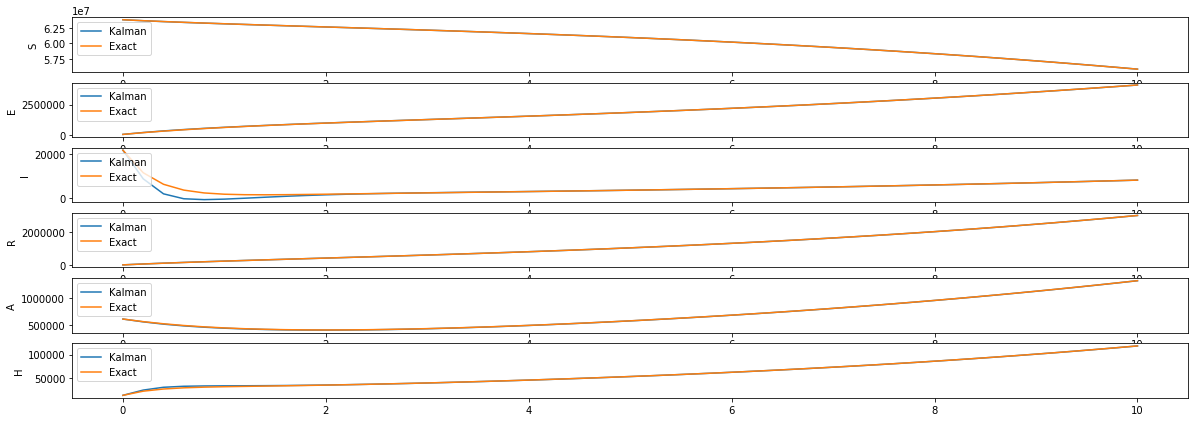

In [4]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(seirah, x0, tseq, args=(theta_true,))

ylabel = ['S', 'E', 'I', 'R', 'A', 'H']
_, axs = plt.subplots(len(ylabel), 1, figsize=(20, 7))
for i in range(len(ylabel)):
    axs[i].plot(tseq, ksim_ei[:, n_deriv_prior[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

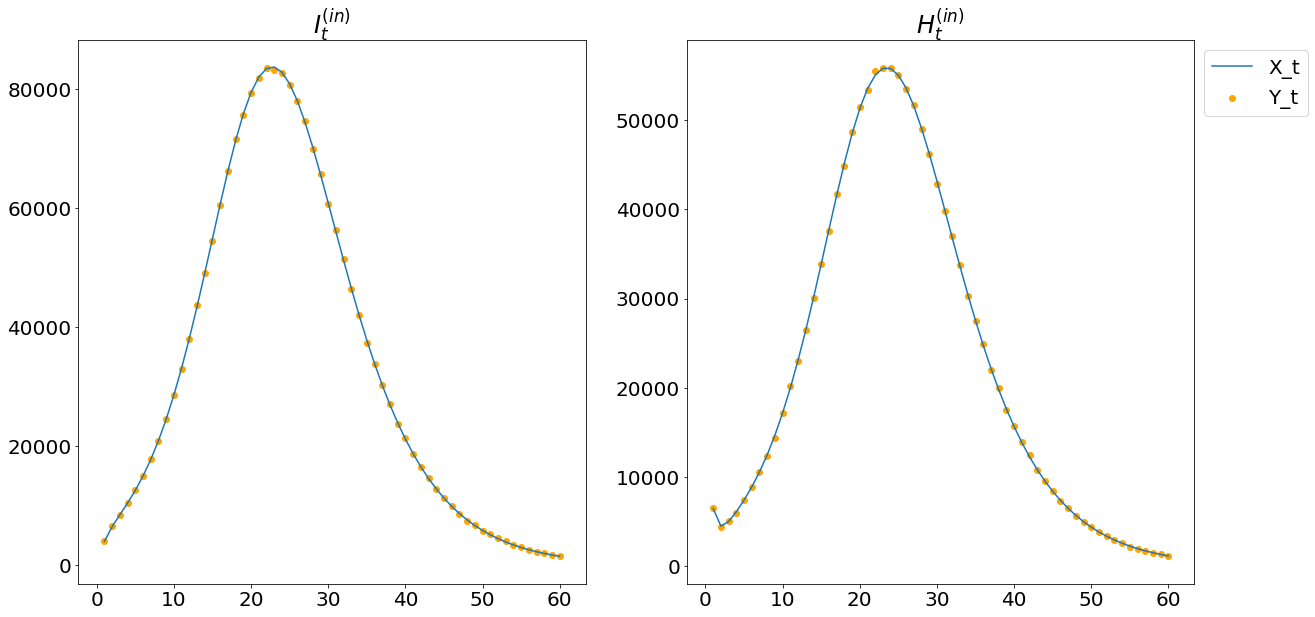

In [2]:
n_deriv = [1]*6 # number of derivatives in IVP
n_deriv_prior = [3]*6 # number of derivatives in IBM prior
state_ind = [0, 3, 6, 9, 12, 15] # Index of 0th derivative of each state

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0
tmax = 60

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 6
sigma = [.5]*n_var

# Initial value, x0, for the IVP
theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 1.13]) # True theta
x0 = np.array([63884630, 15492, 21752, 0, 618013, 13388])

# W matrix: dimension is n_eq x sum(n_deriv)
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

# logprior parameters
n_theta = len(theta_true)

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, seirah, W)
inf.funpad = seirahpad
obs_t = 1
tseq = np.linspace(tmin, tmax, int((tmax-tmin)/obs_t) + 1)
Y_t, X_t = inf.simulate(seirah, x0, theta_true, tseq)
Y_t = Y_t[1:]
X_t = X_t[1:]

# Plot observations and true value
plot_tseq = np.linspace(1, tmax, int((tmax-1)/obs_t)+1)
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(plot_tseq,  X_t[:,0], label = 'X_t')
axs[0].scatter(plot_tseq, Y_t[:,0], label = 'Y_t', color='orange')
axs[0].set_title("$I^{(in)}_t$")
axs[1].plot(plot_tseq, X_t[:,1], label = 'X_t')
axs[1].scatter(plot_tseq, Y_t[:,1], label = 'Y_t', color='orange')
axs[1].set_title("$H^{(in)}_t$")
axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])

In [61]:
import pandas as pd
df = pd.DataFrame(Y_t, columns=["$I_t^{(in)}$", "$H_t^{(in)}$"])
df['Time'] = plot_tseq
df.to_csv("SEIRAH.csv")

In [11]:
inf = inference(state_ind, tmin, tmax, seirah)
inf.funpad = seirahpad
hlst = np.array([.05])
dt = 1
theta_euler = np.zeros((len(hlst), n_samples, n_theta+2))
theta_kalman = np.zeros((len(hlst), n_samples, n_theta+2))
phi_init = np.append(np.log(theta_true), np.array([15492, 21752]))
#phi_init = np.log(theta_true)
phi_mean = np.zeros(n_theta)
phi_sd = np.log(10)*np.ones(n_theta)
xx0 = np.array([63884630, None, None, 0, 618013, 13388])

In [6]:
for i in range(len(hlst)):
    phi_hat, phi_var = inf.phi_fit(Y_t, xx0, hlst[i], dt, phi_mean, phi_sd, inf.euler_nlpost, 
                                   inf.euler_solve, inf.loglike_pois, phi_init=phi_init, auto=False)
    phi_sample = inf.phi_sample(phi_hat, phi_var, n_samples)
    theta_sample = np.exp(phi_sample[:, :n_theta])
    theta_euler[i] = np.abs(np.append(theta_sample, phi_sample[:, n_theta:], axis=1))

In [12]:
for i in range(len(hlst)):
    print(hlst[i])
    ode_init= ibm_init(hlst[i], n_deriv_prior, sigma)
    kinit = indep_init(ode_init, n_deriv_prior)
    kinit = dict((k, jnp.array(v)) for k, v in kinit.items())
    n_eval = int((tmax-tmin)/hlst[i])
    inf.n_eval = n_eval
    inf.kinit = kinit
    inf.W = W
    phi_hat, phi_var = inf.phi_fit(Y_t, xx0, hlst[i], dt, phi_mean, phi_sd, inf.kalman_nlpost, 
                                   inf.kalman_solve, inf.loglike_pois, phi_init=phi_init)
    phi_sample = inf.phi_sample(phi_hat, phi_var, n_samples)
    theta_sample = np.exp(phi_sample[:, :n_theta])
    theta_kalman[i] = np.abs(np.append(theta_sample, phi_sample[:, n_theta:], axis=1)) 

0.05


In [15]:
theta_euler.shape

(5, 100000, 8)

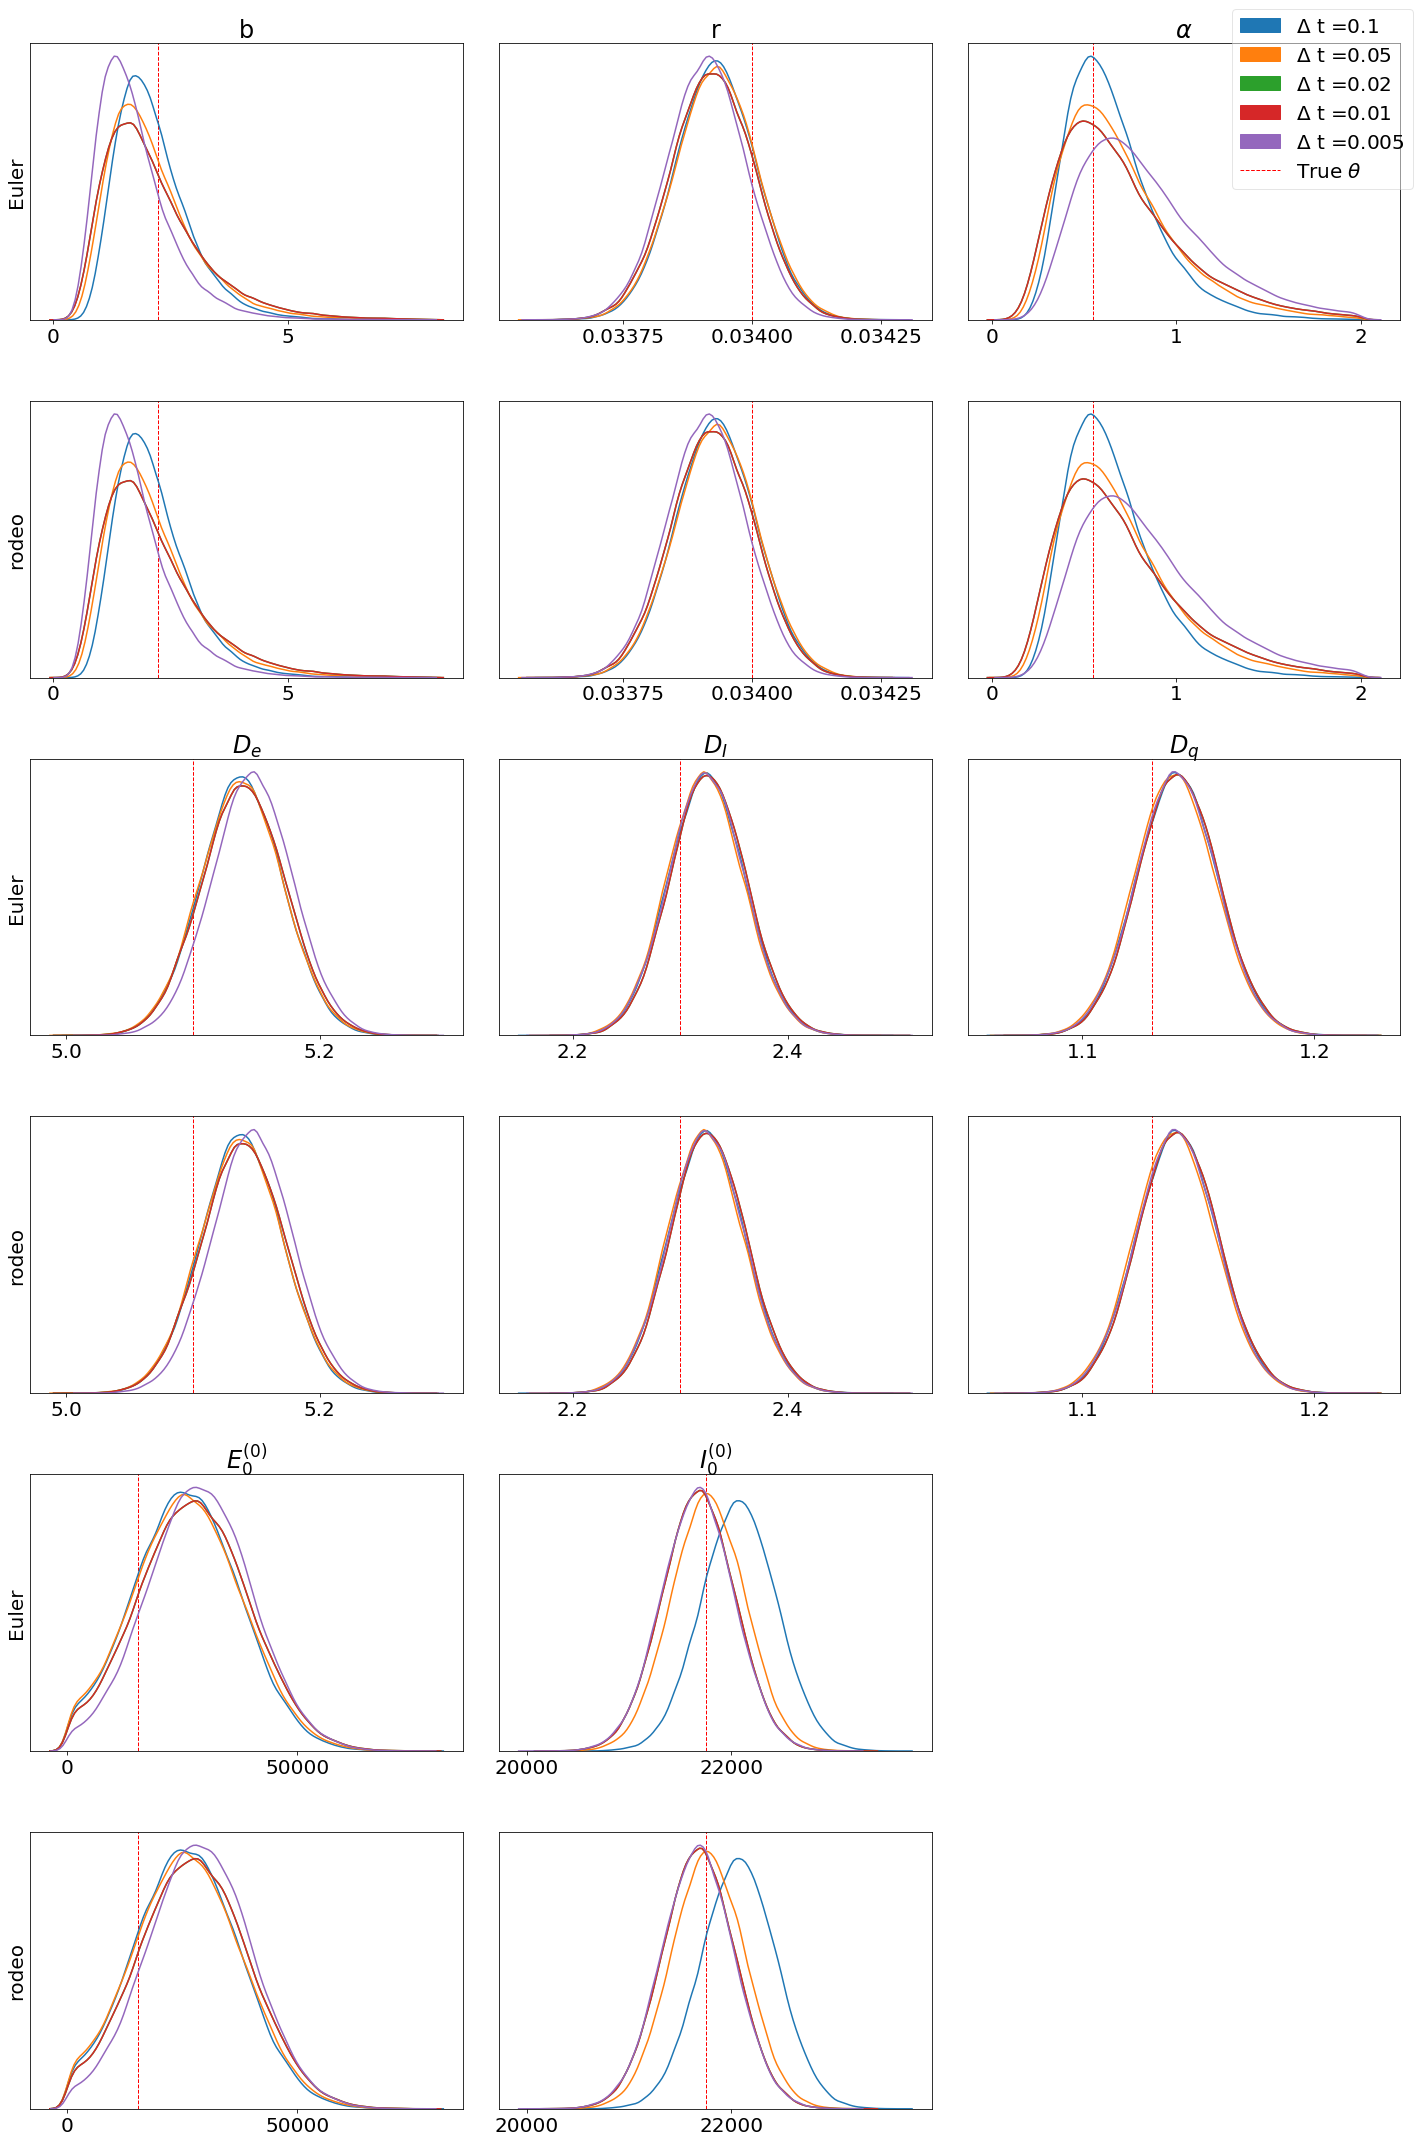

In [17]:
theta_euler = np.load('saves/seirah_theta_euler8.npy')
theta_kalman = np.load('saves/seirah_theta_kalman8.npy')
hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
var_names = ["b", "r", r"$\alpha$", "$D_e$", "$D_I$", "$D_q$", "$E_0^{(0)}$", "$I_0^{(0)}$"]
plt.rcParams.update({'font.size': 20})
clip = [(0, 8), None, (0,2), None, None, None, None, None]
param_true = np.append(theta_true, np.array([15492, 21752]))
figure = inf.theta_plot(theta_kalman[:,:,:], theta_kalman[:,:,:], param_true, hlst, var_names, clip=clip, rows=3)
#figure.savefig('figures/seirahfigure3.pdf')
plt.show()

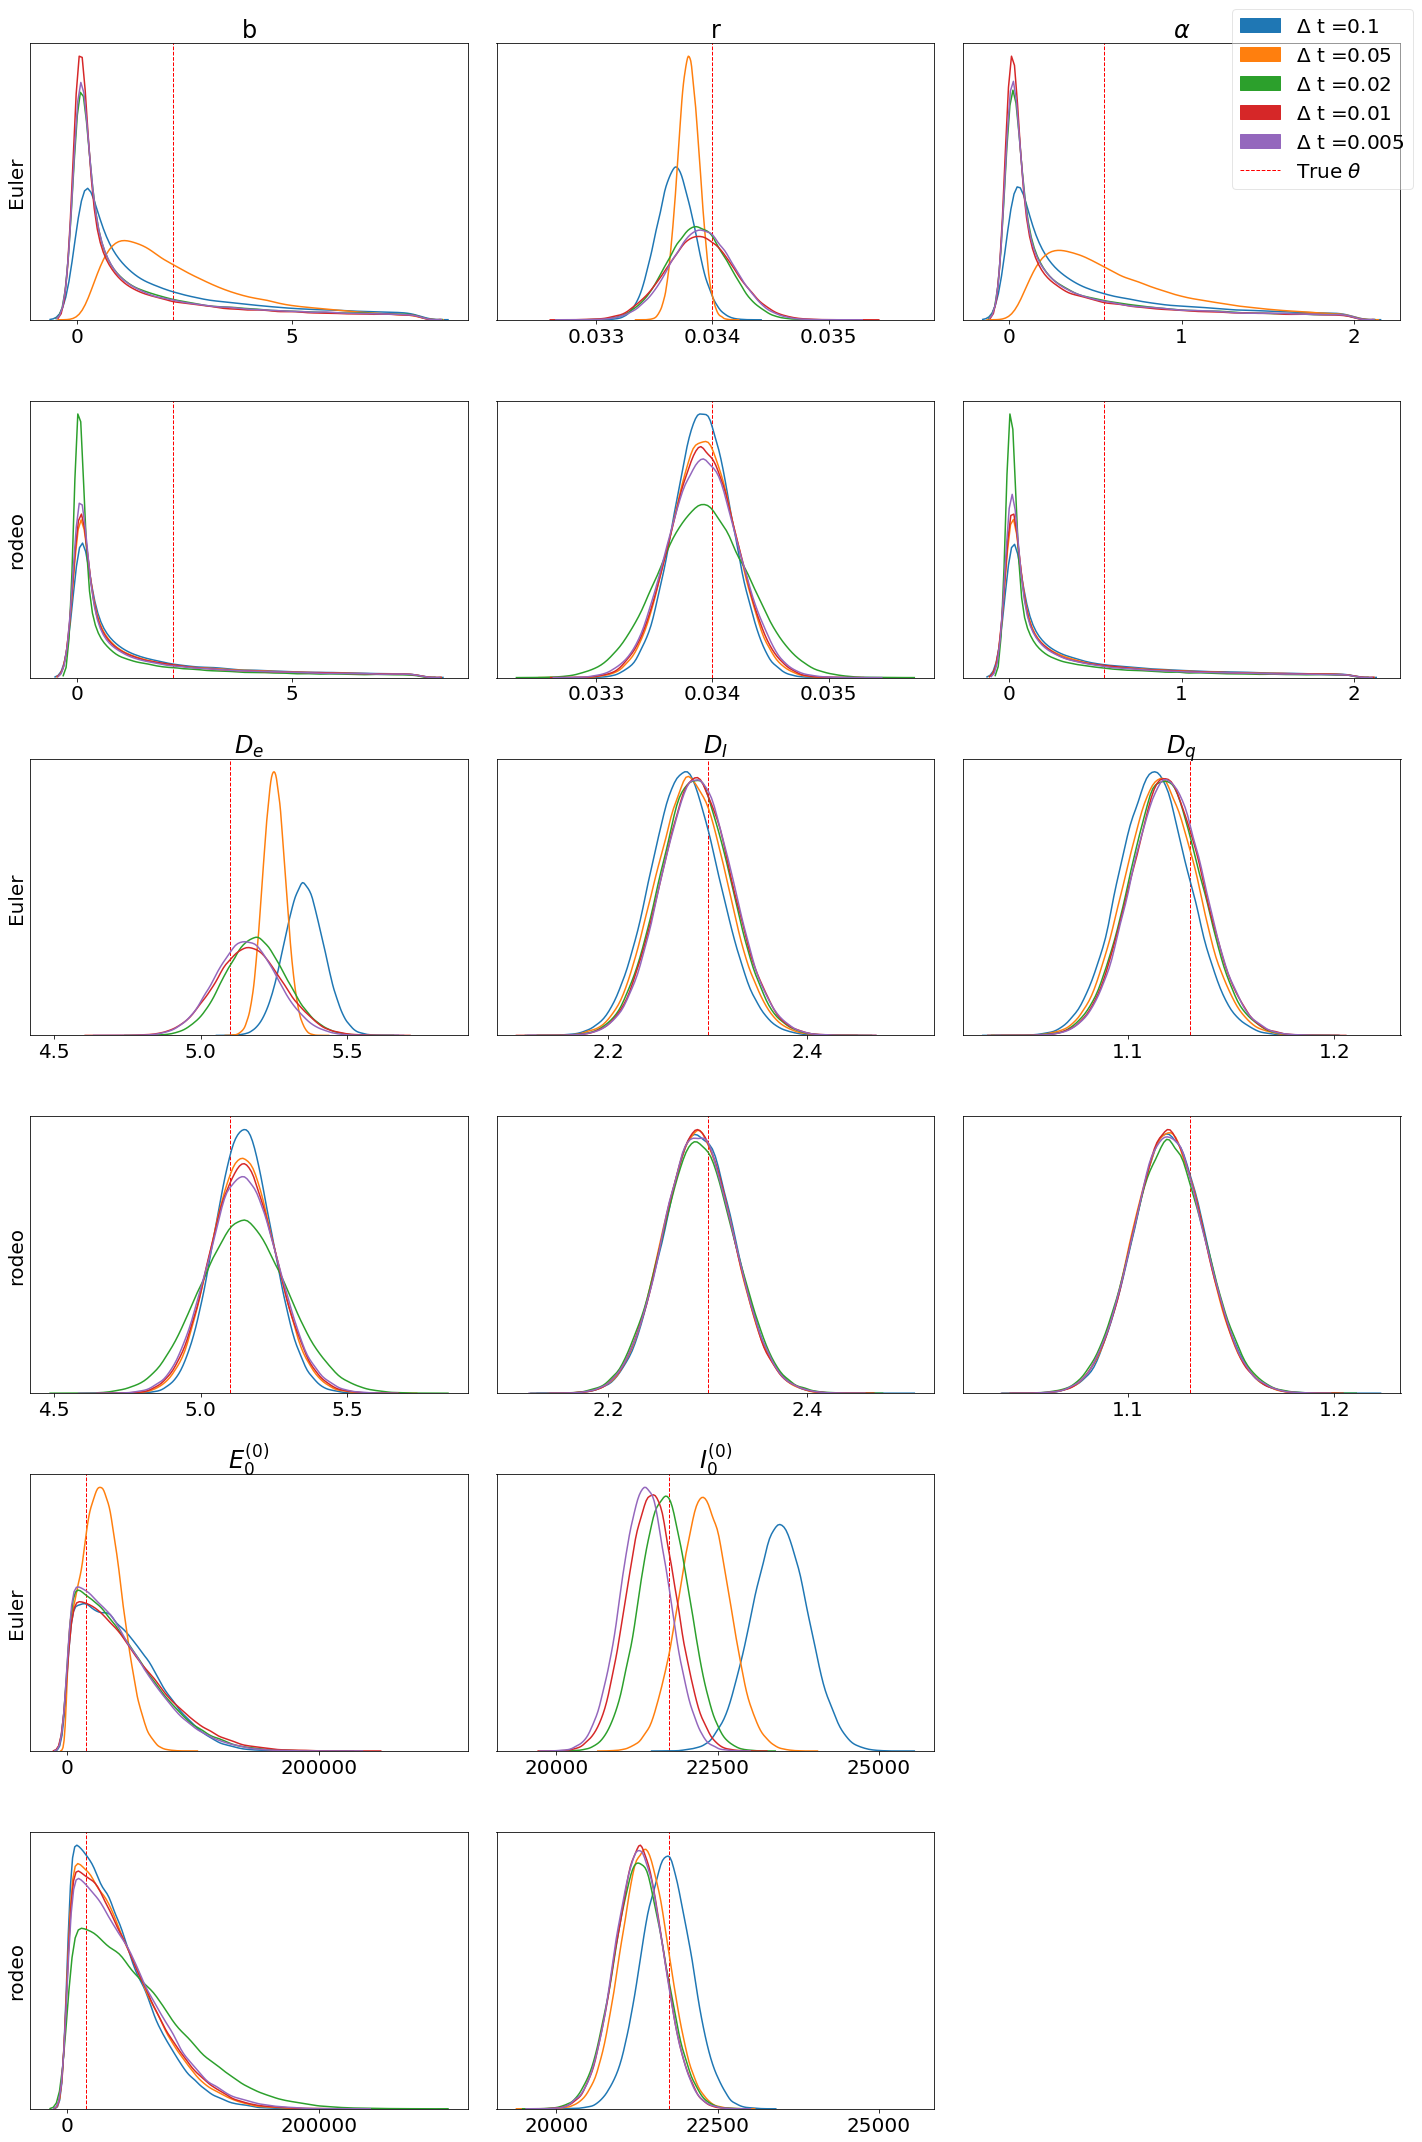

In [21]:
theta_euler = np.load('saves/seirah_theta_euler7.npy')
#theta_kalman = np.load('saves/seirah_theta_kalman7.npy')
var_names = ["b", "r", r"$\alpha$", "$D_e$", "$D_I$", "$D_q$", "$E_0^{(0)}$", "$I_0^{(0)}$"]
plt.rcParams.update({'font.size': 20})
clip = [(0, 8), None, (0,2), None, None, None, None, None]
param_true = np.append(theta_true, np.array([15492, 21752]))
figure = inf.theta_plot(theta_euler[:,:,:], theta_euler[:,:,:], param_true, hlst, var_names, clip=clip, rows=3)
figure.savefig('figures/seirahfigure3.pdf')
plt.show()

In [1]:
import numpy as np
from inference.covid import covid as inference
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def seirah(X_t, t, theta, x_out=None):
    "SEIRAH ODE function"
    if x_out is None:
        x_out = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q = theta
    D_h = 30
    x_out[0] = -b*S*(I + alpha*A)/N
    x_out[1] = b*S*(I + alpha*A)/N - E/D_e
    x_out[2] = r*E/D_e - I/D_q - I/D_I
    x_out[3] = (I + A)/D_I + H/D_h
    x_out[4] = (1-r)*E/D_e - A/D_I
    x_out[5] = I/D_q - H/D_h
    return x_out

def seirahpad(X_t, t, phi):
    theta = np.exp(phi)
    x_der = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q = theta
    D_h = 30
    x_der[0] = -b*S*(I + alpha*A)/N
    x_der[1] = b*S*(I + alpha*A)/N - E/D_e
    x_der[2] = r*E/D_e - I/D_q - I/D_I
    x_der[3] = (I + A)/D_I + H/D_h
    x_der[4] = (1-r)*E/D_e - A/D_I
    x_der[5] = I/D_q - H/D_h
    return np.double(np.ravel([X_t[::p], x_der, np.zeros(6)], "F"))

def seirah_example(load_calcs=False):
    n_deriv = [1]*6 # number of derivatives in IVP
    n_deriv_prior = [3]*6 # number of derivatives in IBM prior
    state_ind = [0, 3, 6, 9, 12, 15] # Index of 0th derivative of each state

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0
    tmax = 60

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    n_var = 6
    sigma = [.5]*n_var

    # Initial value, x0, for the IVP
    theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 1.13]) # True theta
    x0 = np.array([63884630, 15492, 21752, 0, 618013, 13388])
    
    # W matrix: dimension is n_eq x sum(n_deriv)
    W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
    for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
    W = zero_pad(W_mat, n_deriv, n_deriv_prior)

    # logprior parameters
    n_theta = len(theta_true)
    phi_mean = np.zeros(n_theta)
    phi_sd = np.log(10)*np.ones(n_theta)

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    inf = inference(state_ind, tmin, tmax, seirah)
    inf.funpad = seirahpad
    Y_t, X_t = inf.simulate(seirah, x0, theta_true)
    np.save("saves/Yt2.npy", Y_t)
    np.save("saves/Xt2.npy", X_t)

    # Plot observations and true value
    tseq = np.linspace(tmin+1, tmax, tmax-tmin)
    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].plot(tseq,  X_t[:,0], label = 'X_t')
    axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
    axs[0].set_title("$I^{(in)}_t$")
    axs[1].plot(tseq, X_t[:,1], label = 'X_t')
    axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
    axs[1].set_title("$H^{(in)}_t$")
    axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])
    fig.savefig('figures/seirahsim2.pdf')

    hlst = np.array([0.1, 0.05, 0.02])
    if load_calcs:
        theta_euler = np.load('saves/seirah_theta_euler6.npy')
        theta_kalman = np.load('saves/seirah_theta_kalman6.npy')
    else:
        theta_euler = np.zeros((len(hlst), n_samples, n_theta+2))
        #theta_euler = np.load('saves/seirah_theta_euler3.npy')
        dt = 1
        phi_init = np.append(np.log(theta_true), np.array([15492, 21752]))
        xx0 = np.array([63884630, None, None, 0, 618013, 13388])
        #bounds = tuple([(None, None)]*6 + [(0, np.inf)]*2)
        for i in range(len(hlst)):
            print(hlst[i])
            phi_hat, phi_var = inf.phi_fit(Y_t, xx0, hlst[i], dt, phi_mean, phi_sd, inf.euler_nlpost, 
                                           inf.euler_solve, inf.loglike_pois, phi_init=phi_init)
            phi_sample = inf.phi_sample(phi_hat, phi_var, n_samples)
            theta_sample = np.exp(phi_sample[:, :n_theta])
            theta_euler[i] = np.abs(np.append(theta_sample, phi_sample[:, n_theta:], axis=1)) 
        np.save('saves/seirah_theta_euler8.npy', theta_euler)
        
        # Parameter inference using Kalman solver
        theta_kalman = np.zeros((len(hlst), n_samples, n_theta+2))
        for i in range(len(hlst)):
            print(hlst[i])
            ode_init= ibm_init(hlst[i], n_deriv_prior, sigma)
            kinit = indep_init(ode_init, n_deriv_prior)
            n_eval = int((tmax-tmin)/hlst[i])
            kode = KalmanODE(W, tmin, tmax, n_eval, seirah, **kinit)
            inf.kode = kode
            inf.W = W
            phi_hat, phi_var = inf.phi_fit(Y_t, xx0, hlst[i], dt, phi_mean, phi_sd, inf.kalman_nlpost, 
                                           inf.kalman_solve, inf.loglike_pois, phi_init=phi_init)
            phi_sample = inf.phi_sample(phi_hat, phi_var, n_samples)
            theta_sample = np.exp(phi_sample[:, :n_theta])
            theta_kalman[i] = np.abs(np.append(theta_sample, phi_sample[:, n_theta:], axis=1)) 
        np.save('saves/seirah_theta_kalman8.npy', theta_kalman)
    
    plt.rcParams.update({'font.size': 20})
    clip = [(0, 8), None, (0, 2), None, None, None, None, None]
    var_names = ["b", "r", r"$\alpha$", "$D_e$", "$D_I$", "$D_q$", "E_0^{(0)}", "I_0^{(0)}"]
    param_true = np.append(theta_true, np.array([15492, 21752]))
    figure = inf.theta_plot(theta_euler[:, :, :], theta_kalman[:, :, :], param_true, hlst, var_names, clip=clip, rows=3)
    #figure.savefig('figures/seirahfigure5.pdf')
    #plt.show()
    return

if __name__ == '__main__':
    seirah_example(False)


0.1
0.05
0.02
0.1
0.05


LinAlgError: 7-th leading minor of the array is not positive definite